# Intro

This notebook implements an experiment aimed to verify accuracy of Deep Hybrid AutoencodeR Recommendation ENgine (DHARREN), on a dataset used in a [recent publication](https://github.com/MengtingWan/marketBias). 

# Technical prep

In [1]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from tqdm.autonotebook import tqdm
from tqdm import trange

/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [5]:
sys.path.append(os.getcwd())

In [6]:
from src.models.training_utils import prepare_experiment_data

# Data prep

In [7]:
experiment_data = prepare_experiment_data()

Processed: 0.0%
Processed: 0.27373261797875836%
Processed: 0.5474652359575167%
Processed: 0.8211978539362751%
Processed: 0.0%
Processed: 0.4555393586005831%
Processed: 0.9110787172011662%
Processed: 0.0%
Processed: 0.6804109682248077%


# Modeling phase

## Experimental setup

In [8]:
def generator_ratings_features(ratings, features, normalize=False, batch_size=64):
    mask = (ratings > 0.0) * 1.0
    while True:
        ratings, mask = shuffle(ratings, mask)
        for i in range(ratings.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, ratings.shape[0])
            r = ratings[i*batch_size:upper].toarray()
            f = features[i * batch_size : upper]
            m = mask[i*batch_size:upper].toarray()
            if normalize:
                #r = r - mu * m
                r = r * m
            yield [r, f], r
            
def generator_ratings(ratings, normalize=False, batch_size=64):
    mask = (ratings > 0.0) * 1.0
    while True:
        ratings, mask = shuffle(ratings, mask)
        print("shuffling the data")
        for i in range(ratings.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, ratings.shape[0])
            r = ratings[i*batch_size:upper].toarray()
            m = mask[i*batch_size:upper].toarray()
            if normalize:
                #r = r - mu * m
                r = r * m
            yield r, r

In [9]:
def mse_masked(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), dtype='float32')
    #y_true = y_true + mu * mask
    #y_pred = y_pred + mu * mask
    y_true = y_true * mask
    y_pred = y_pred * mask
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = tf.reduce_sum(tf.reduce_sum(sqdiff))
    n = tf.reduce_sum(tf.reduce_sum(mask))
    return sse / n

def mape_masked(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32')
    
    y_true = y_true * mask
    y_pred = y_pred * mask
    
    return tf.reduce_mean( (y_true[y_true > 0.0] - y_pred[y_true > 0.0])/y_true[y_true > 0.0] )

def mae_masked(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32')
    #y_true = y_true + mu * mask
    #y_pred = y_pred + mu * mask
    #y_true = y_true * mask
    #y_pred = y_pred * mask
    mape = tf.keras.losses.MeanAbsoluteError()
    return mape(y_true * mask, y_pred * mask)


## Collaborative filtering

Deep collaborative filtering implementation can be inspired by the following tutorial:

https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929


Other working implementation:

https://www.smartlab.at/articles/implement-a-book-recommendation-system-with-tensorflow/

Implementation in Keras:

https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/

Other implementation using embeddings

https://github.com/CVxTz/Recommender_keras

In [10]:
def collaborative_filtering(n_users, n_items, n_factors, ratings):
    K = 256 # number of hidden features
    P = np.random.rand(n_users,K)
    Q = np.random.rand(n_items,K)

    # build model
    pMultq = tf.matmul(P, Q, transpose_b=True)

    squared_deltas = tf.square(pMultq - ratings)
    loss = tf.reduce_sum(squared_deltas)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('sumP', tf.reduce_sum(tP))
    tf.summary.scalar('sumQ', tf.reduce_sum(tQ))
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(loss)

In [11]:
def get_collabfiltering_model1(max_user, max_item, dim_embedddings=30):
    bias = 3
    # inputs
    w_inputs = tf.keras.layers.Input(shape=(1,), dtype='int32')
    w = tf.keras.layers.Embedding(max_item+1, dim_embedddings, name="items")(w_inputs)

    # context
    u_inputs = tf.keras.layers.Input(shape=(1,), dtype='int32')
    u = tf.keras.layers.Embedding(max_user+1, dim_embedddings, name="user")(u_inputs)
    o = tf.keras.layers.multiply([w, u])
    o = tf.keras.layers.Dropout(0.5)(o)
    o = tf.keras.layers.Flatten()(o)
    o = tf.keras.layers.Dense(1)(o)

    rec_model = tf.keras.models.Model(inputs=[w_inputs, u_inputs], outputs=o)
    #rec_model.summary()
    rec_model.compile(loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked], optimizer='adam')

    return rec_model

In [12]:
X_colab_all = np.vstack((experiment_data.Xratings_train.todense(), experiment_data.Xratings_valid.todense()))

In [13]:
X_colab_all.shape

(40670, 6556)

In [14]:
nusers = X_colab_all.shape[0]
nitems = X_colab_all.shape[1]
factors = 128

### Tensorflow impl.

In [15]:
K = 128 # number of hidden features
initializer = tf.initializers.GlorotUniform()
P = tf.Variable(initializer((nusers, K)))
Q = tf.Variable(initializer((nitems, K)))

# build model

ratings = X_colab_all.astype(np.float64)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

losses = []

for i in tqdm(range(20)):
    with tf.GradientTape() as t:
        pMultq = tf.matmul(P, Q, transpose_b=True)
        squared_deltas = tf.square(pMultq - ratings)
        loss = tf.reduce_sum(squared_deltas)
    grad = t.gradient(loss, [P, Q])
    optimizer.apply_gradients(zip(grad, [P, Q]))
    losses.append(loss)
    print(loss)

tf.Tensor(987703.06, shape=(), dtype=float32)
tf.Tensor(983425.2, shape=(), dtype=float32)
tf.Tensor(977308.06, shape=(), dtype=float32)
tf.Tensor(968911.25, shape=(), dtype=float32)
tf.Tensor(958860.7, shape=(), dtype=float32)
tf.Tensor(947794.44, shape=(), dtype=float32)
tf.Tensor(936090.5, shape=(), dtype=float32)
tf.Tensor(923689.25, shape=(), dtype=float32)
tf.Tensor(910765.06, shape=(), dtype=float32)
tf.Tensor(897606.9, shape=(), dtype=float32)
tf.Tensor(884266.2, shape=(), dtype=float32)
tf.Tensor(870807.7, shape=(), dtype=float32)
tf.Tensor(857447.44, shape=(), dtype=float32)
tf.Tensor(844228.06, shape=(), dtype=float32)
tf.Tensor(831196.0, shape=(), dtype=float32)
tf.Tensor(818606.1, shape=(), dtype=float32)
tf.Tensor(806586.7, shape=(), dtype=float32)
tf.Tensor(795121.8, shape=(), dtype=float32)
tf.Tensor(784416.7, shape=(), dtype=float32)


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x1a459b57d0>
Traceback (most recent call last):
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/tqdm/notebook.py", line 227, in __iter__
    self.sp(bar_style='danger')
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/tqdm/notebook.py", line 183, in display
    pbar.bar_style = bar_style
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/traitlets/traitlets.py", line 1139, in _notify_trait
    type='change',
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 603, in notify_change
    if name in self.keys and 

Traceback (most recent call last):
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-fcb7bb7213e1>", line 16, in <module>
    squared_deltas = tf.square(pMultq - ratings)
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/math_ops.py", line 903, in binary_op_wrapper
    y, dtype_hint=x.dtype.base_dtype, name="y")
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1242, in convert_to_tensor_v2
    as_ref=False)
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1284, in internal_convert_to_tensor
    value, dtype=preferred_dtype, name=name, as_ref=as_ref)
  File "/Users/filipwojcik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/tenso

KeyboardInterrupt: 

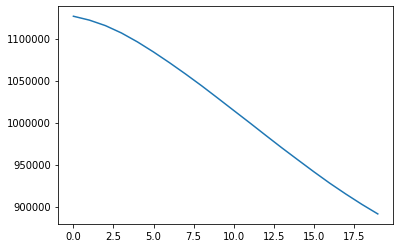

In [91]:
plt.plot(losses)

### Keras impl

In [151]:
def get_array(series):
    return np.array([[element] for element in series])

In [152]:
from sklearn.preprocessing import LabelEncoder
uid_encoder = LabelEncoder()
mid_encoder = LabelEncoder()

uide = get_array(uid_encoder.fit_transform(X_train_raw.user_id))
mide = get_array(mid_encoder.fit_transform(X_train_raw.item_id))
rr = get_array(np.array(X_train_raw.rating))

In [153]:
colab_keras = get_collabfiltering_model1(np.max(uide) + 1, np.max(mide) + 1)

In [154]:
colab_keras.fit([mide, uide], rr, epochs=10,
                    validation_split=0.2, verbose=1)

Train on 35130 samples, validate on 8783 samples
Epoch 1/10
35130/35130 [==============================] - 9s 257us/sample - loss: 15.1171 - mse_masked: 15.1164 - mape_masked: 0.8488 - mae_masked: 3.6912 - val_loss: 11.7949 - val_mse_masked: 11.7968 - val_mape_masked: 0.7027 - val_mae_masked: 3.2196
Epoch 2/10
35130/35130 [==============================] - 8s 214us/sample - loss: 8.7770 - mse_masked: 8.7765 - mape_masked: 0.5669 - mae_masked: 2.7640 - val_loss: 6.7827 - val_mse_masked: 6.7835 - val_mape_masked: 0.4408 - val_mae_masked: 2.4353
Epoch 3/10
35130/35130 [==============================] - 7s 207us/sample - loss: 4.3500 - mse_masked: 4.3498 - mape_masked: 0.2928 - mae_masked: 1.9204 - val_loss: 3.9088 - val_mse_masked: 3.9088 - val_mape_masked: 0.2264 - val_mae_masked: 1.8574
Epoch 4/10
35130/35130 [==============================] - 8s 215us/sample - loss: 1.8232 - mse_masked: 1.8232 - mape_masked: 0.0545 - mae_masked: 1.2052 - val_loss: 2.6254 - val_mse_masked: 2.6247 - val_

## Autoencoders

### Model definitions

#### Shallow single

In [16]:
def build_shallow_autorec_single_input(X_shape):
    inp = tf.keras.layers.Input(shape=(X_shape, ))
    drop1 = tf.keras.layers.Dropout(rate=0.2)(inp)
    enc = tf.keras.layers.Dense(X_shape // 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
    drop2 = tf.keras.layers.Dropout(rate=0.2)(enc)
    out = tf.keras.layers.Dense(X_shape, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

#### Deep single

In [17]:
def build_deep_autorec_single_input(X_shape):
    inp = tf.keras.layers.Input(shape=(X_shape, ))
    drop1 = tf.keras.layers.Dropout(rate=0.2)(inp)
    enc1 = tf.keras.layers.Dense(X_shape // 4, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(rate=0.2)(enc1)
    enc2 = tf.keras.layers.Dense(X_shape // 8, activation='relu')(drop2)
    drop3 = tf.keras.layers.Dropout(rate=0.2)(enc2)
    dec1 = tf.keras.layers.Dense(X_shape // 4, activation='relu')(drop3)
    drop4 = tf.keras.layers.Dropout(rate=0.2)(dec1)
    out = tf.keras.layers.Dense(X_shape, activation='relu')(drop4)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

#### Multi

In [18]:
def build_autorec_multi_input(X_shape, F_shape):  
    inp1 = tf.keras.layers.Input(shape=(X_shape, ))
    inp2 = tf.keras.layers.Input(shape=(F_shape, ))
    concat = tf.keras.layers.Concatenate()
    combined = concat([inp1, inp2])
    drop1 = tf.keras.layers.Dropout(rate=0.1)(combined)
    #bnorm = tf.keras.layers.BatchNormalization()(drop1)
    enc = tf.keras.layers.Dense(
        X_shape // 4, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
    drop2 = tf.keras.layers.Dropout(rate=0.1)(enc)
    out = tf.keras.layers.Dense(
        X_shape,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
    model = tf.keras.models.Model(inputs=[inp1, inp2], outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

In [19]:
def build_autorec_multi_input2(X_shape, F_shape):  
    inp1 = tf.keras.layers.Input(shape=(X_shape, ))
    inp2 = tf.keras.layers.Input(shape=(F_shape, ))
    concat = tf.keras.layers.Concatenate()
    drop1 = tf.keras.layers.Dropout(rate=0.1)(inp1)
    #bnorm = tf.keras.layers.BatchNormalization()(drop1)
    enc = tf.keras.layers.Dense(
        X_shape // 4, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
    combined = concat([enc, inp2])
    drop2 = tf.keras.layers.Dropout(rate=0.3)(combined)
    enc2 = tf.keras.layers.Dense(
        X_shape // 16, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
    drop3 = tf.keras.layers.Dropout(rate=0.3)(enc2)
    dec =  tf.keras.layers.Dense(
        X_shape // 4, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop3)
    drop4 = tf.keras.layers.Dropout(rate=0.3)(dec)
    out = tf.keras.layers.Dense(
        X_shape,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop4)
    model = tf.keras.models.Model(inputs=[inp1, inp2], outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

### Train shallow

In [22]:
batch_size = 64
steps_per_epoch = experiment_data.Xratings_train.shape[0] // batch_size

shallow_autorec = build_shallow_autorec_single_input(experiment_data.Xratings_train.shape[1])
results_autorec_simple = shallow_autorec.fit_generator(
    generator_ratings(experiment_data.Xratings_train, batch_size), 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=(experiment_data.Xratings_valid.toarray().astype(np.float32), experiment_data.Xratings_valid.toarray().astype(np.float32))
    )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6556)]            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6556)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 819)               5370183   
_________________________________________________________________
dropout_3 (Dropout)          (None, 819)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6556)              5375920   
Total params: 10,746,103
Trainable params: 10,746,103
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
shuffling the data
 88/317 [=======>......................] - ETA: 1:28 - loss: 14.9381 - mse_mas

KeyboardInterrupt: 

In [115]:
Xr_test_reconstruction_shallow = shallow_autorec.predict(Xr_test_pred_hidden.toarray())

In [116]:
mse_masked(Xr_test_pred_hidden.toarray(), Xr_test_reconstruction_shallow)

<tf.Tensor: shape=(), dtype=float32, numpy=2.7479384>

In [117]:
yhat = []
for test_uid, test_itemid in zip(test_uids, test_item_ids):
    yhat.append(Xr_test_reconstruction_shallow[test_uid, test_itemid])

In [118]:
mse_masked(test_y, yhat).numpy(), mape_masked(test_y, yhat).numpy(), mae_masked(test_y, yhat).numpy()

(3.2167392, -0.015748145, 1.4263917)

### Train multi input

In [184]:

batch_size = 64
steps_per_epoch = Xr_train.shape[0] // batch_size

deep_autorec_multi = build_autorec_multi_input2(user_item_matrix.shape[1], features_matrix.shape[1])
results_autorec_multi = deep_autorec_multi.fit_generator(
    generator_ratings_features(Xr_train, Xf_train, batch_size), 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=([Xr_val.toarray().astype(np.float32), Xf_val], Xr_val.toarray().astype(np.float32))
    )

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 9560)]       0                                            
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 9560)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2390)         22850790    dropout_12[0][0]                 
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 57)]         0                                            
____________________________________________________________________________________________

In [187]:
Xr_test_reconstruction_multi = deep_autorec_multi.predict([Xr_test_pred_hidden.toarray(), Xf_test])
mse_masked(Xr_test_pred_hidden.toarray(), Xr_test_reconstruction_multi).numpy()

2.9584022

In [188]:
yhat_multi = []
for test_uid, test_itemid in zip(test_uids, test_item_ids):
    yhat_multi.append(Xr_test_reconstruction_multi[test_uid, test_itemid])
    
mse_masked(test_y, yhat_multi).numpy(), mape_masked(test_y, yhat_multi).numpy(), mae_masked(test_y, yhat_multi).numpy()

(3.5427463, 0.012227664, 1.4799496)

In [189]:
pd.DataFrame({'y': test_y, 'yhat': yhat_multi})

,y,yhat
0,4,3.707496
1,5,3.352658
2,4,3.824492
3,5,3.861844
4,2,5.124014
...,...,...
119,5,4.234419
120,4,3.796869
121,5,1.594608
122,3,2.677118


In [190]:
from sklearn.metrics import r2_score

r2_score(test_y, yhat_multi)

-1.0414206115887032

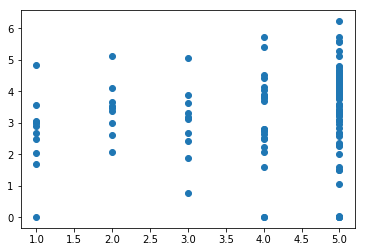

In [191]:
plt.scatter(test_y, yhat_multi)

# Memory cleanup

In [192]:
import gc
tf.keras.backend.clear_session()
gc.collect()

28473